# Testing the Empirically-Derived Complexity Vector

From the 2D scan analysis, we fitted a plane: `GL = 1.7515·α + -1.1521·β + 11.5398`

The gradient of this plane gives us an **empirically measured** complexity direction:

```
V_measured = 1.7515·V_complexity + (-1.1521)·V_perpendicular
```

**Question:** Does steering along V_measured produce a cleaner relationship than the original semantic V_complexity?

**Method:**
1. Reconstruct V_measured from the plane fit coefficients
2. Normalize to ||V_measured|| = ||V_complexity|| = 87.0
3. Perform 1D sweep: γ ∈ [-5, +5] along V_measured
4. Compare to original 1D sweep along α·V_complexity

**What we're testing:**
- Empirical terrain mapping vs semantic contrast-pair extraction
- Does V_measured avoid the α≈0.25 discontinuity?
- Is the relationship more linear?

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import textstat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

## Configuration

In [2]:
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
STEERING_LAYER = 35

# From plane fit in notebook 06
COEF_ALPHA = 1.7515  # Coefficient for V_complexity
COEF_BETA = -1.1521  # Coefficient for V_perpendicular

# Sweep configuration
TEST_PROMPT = "Can you explain quantum mechanics please?"
GAMMA_MIN = -5.0
GAMMA_MAX = 5.0
GAMMA_STEP = 0.1

# Generation parameters
MAX_NEW_TOKENS = 200

# Paths
VECTORS_DIR = "vectors/Qwen3-4B-Instruct-2507"
OUTPUT_CSV = "data/measured_vector_sweep.csv"

print(f"Device: {DEVICE}")
print(f"Sweep: γ ∈ [{GAMMA_MIN}, {GAMMA_MAX}], step {GAMMA_STEP}")
print(f"Total points: {int((GAMMA_MAX - GAMMA_MIN) / GAMMA_STEP + 1)}")

Device: mps
Sweep: γ ∈ [-5.0, 5.0], step 0.1
Total points: 101


## Step 1: Load Vectors and Construct V_measured

In [3]:
# Load the original vectors
complexity_vectors = torch.load(f"{VECTORS_DIR}/complexity_vectors.pt")
v_complexity = complexity_vectors[STEERING_LAYER]
v_perpendicular = torch.load(f"{VECTORS_DIR}/perpendicular_vector.pt")

print(f"Loaded vectors for layer {STEERING_LAYER}")
print(f"V_complexity shape: {v_complexity.shape}")
print(f"V_perpendicular shape: {v_perpendicular.shape}")
print(f"||V_complexity|| = {torch.norm(v_complexity.float()).item():.4f}")
print(f"||V_perpendicular|| = {torch.norm(v_perpendicular.float()).item():.4f}")

# Verify orthogonality
dot = torch.dot(v_complexity.float(), v_perpendicular.float()).item()
print(f"\nOrthogonality check: {dot:.6f} (should be ~0)")

Loaded vectors for layer 35
V_complexity shape: torch.Size([2560])
V_perpendicular shape: torch.Size([2560])
||V_complexity|| = 87.0327
||V_perpendicular|| = 87.0360

Orthogonality check: 0.172432 (should be ~0)


In [4]:
# Construct V_measured from plane fit coefficients
v_measured_f32 = COEF_ALPHA * v_complexity.float() + COEF_BETA * v_perpendicular.float()

# Get the target norm (||V_complexity||)
target_norm = torch.norm(v_complexity.float()).item()
measured_norm = torch.norm(v_measured_f32).item()

# Normalize to match V_complexity magnitude
v_measured_normalized = v_measured_f32 * (target_norm / measured_norm)

# Convert to bfloat16 for model
v_measured = v_measured_normalized.bfloat16()

print("V_measured construction:")
print(f"  V_measured = {COEF_ALPHA:.4f}·V_complexity + {COEF_BETA:.4f}·V_perpendicular")
print(f"\nBefore normalization:")
print(f"  ||V_measured|| = {measured_norm:.4f}")
print(f"\nAfter normalization:")
print(f"  ||V_measured|| = {torch.norm(v_measured.float()).item():.4f}")
print(f"  ||V_complexity|| = {target_norm:.4f}")
print(f"\n✓ V_measured ready for steering")

V_measured construction:
  V_measured = 1.7515·V_complexity + -1.1521·V_perpendicular

Before normalization:
  ||V_measured|| = 182.4598

After normalization:
  ||V_measured|| = 87.0299
  ||V_complexity|| = 87.0327

✓ V_measured ready for steering


## Step 2: Load Model

In [5]:
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() or torch.backends.mps.is_available() else torch.float32,
    device_map="auto",
)
model.eval()
print("✓ Model loaded")

Loading model: Qwen/Qwen3-4B-Instruct-2507


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Model loaded


## Step 3: Define Steering Function

In [6]:
def generate_with_steering(prompt, steering_vector, coefficient):
    """
    Generate text with activation steering.
    
    Args:
        prompt: The text prompt
        steering_vector: The vector to steer along (V_measured)
        coefficient: How much to steer (γ)
    
    Returns:
        Generated text
    """
    # Format prompt
    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    # Tokenize
    inputs = tokenizer(formatted_prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Compute full steering vector
    full_steering = (coefficient * steering_vector).to(model.device)
    
    # Define steering hook
    def steering_hook(module, input, output):
        if isinstance(output, tuple):
            hidden_states = output[0]
        else:
            hidden_states = output
        
        steered = hidden_states + full_steering
        
        if isinstance(output, tuple):
            return (steered,) + output[1:]
        else:
            return steered
    
    # Register hook
    hook_handle = model.model.layers[STEERING_LAYER].register_forward_hook(steering_hook)
    
    try:
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                do_sample=False,  # Greedy decoding
            )
        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    finally:
        hook_handle.remove()
    
    # Extract assistant response
    if "<|im_start|>assistant" in full_text:
        generated_text = full_text.split("<|im_start|>assistant", 1)[1]
        generated_text = generated_text.lstrip('\n')
    else:
        generated_text = full_text[len(prompt):].strip()
    
    # Clean up special tokens
    for token in ["<|im_end|>", "<|endoftext|>", "<|eot_id|>"]:
        if token in generated_text:
            generated_text = generated_text.split(token)[0]
    
    return generated_text.strip()


def analyze_text(text):
    """Compute Flesch-Kincaid grade level and other metrics."""
    if not text or len(text.strip()) < 10:
        return {
            'flesch_kincaid_grade': 0.0,
            'word_count': 0,
            'sentence_count': 0,
        }
    
    try:
        return {
            'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
            'word_count': textstat.lexicon_count(text, removepunct=True),
            'sentence_count': textstat.sentence_count(text),
        }
    except:
        return {
            'flesch_kincaid_grade': 0.0,
            'word_count': 0,
            'sentence_count': 0,
        }

print("✓ Functions defined")

✓ Functions defined


## Step 4: Run 1D Sweep Along V_measured

In [7]:
start_time = datetime.now()
print(f"Starting 1D sweep along V_measured at {start_time.strftime('%H:%M:%S')}")
print(f"Range: γ ∈ [{GAMMA_MIN}, {GAMMA_MAX}], step {GAMMA_STEP}\n")

gammas = np.arange(GAMMA_MIN, GAMMA_MAX + GAMMA_STEP/2, GAMMA_STEP)
results = []

for i, gamma in enumerate(gammas, 1):
    print(f"[{i}/{len(gammas)}] γ = {gamma:+.1f}...", end=" ")
    
    # Generate
    text = generate_with_steering(TEST_PROMPT, v_measured, gamma)
    
    # Analyze
    metrics = analyze_text(text)
    
    results.append({
        'gamma': gamma,
        'generated_text': text,
        **metrics
    })
    
    print(f"GL = {metrics['flesch_kincaid_grade']:.2f}")

df = pd.DataFrame(results)
end_time = datetime.now()
elapsed = (end_time - start_time).total_seconds() / 60

print(f"\n✓ Sweep complete in {elapsed:.1f} minutes")
print(f"Average time per point: {elapsed*60/len(gammas):.2f} seconds")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Starting 1D sweep along V_measured at 19:31:05
Range: γ ∈ [-5.0, 5.0], step 0.1

[1/101] γ = -5.0... GL = 13.69
[2/101] γ = -4.9... GL = 7.11
[3/101] γ = -4.8... GL = 8.16
[4/101] γ = -4.7... GL = 7.49
[5/101] γ = -4.6... GL = 7.42
[6/101] γ = -4.5... GL = 7.42
[7/101] γ = -4.4... GL = 8.54
[8/101] γ = -4.3... GL = 8.35
[9/101] γ = -4.2... GL = 8.35
[10/101] γ = -4.1... GL = 8.35
[11/101] γ = -4.0... GL = 8.06
[12/101] γ = -3.9... GL = 8.15
[13/101] γ = -3.8... GL = 6.36
[14/101] γ = -3.7... GL = 8.44
[15/101] γ = -3.6... GL = 7.63
[16/101] γ = -3.5... GL = 7.21
[17/101] γ = -3.4... GL = 7.23
[18/101] γ = -3.3... GL = 6.98
[19/101] γ = -3.2... GL = 7.57
[20/101] γ = -3.1... GL = 6.81
[21/101] γ = -3.0... GL = 6.98
[22/101] γ = -2.9... GL = 6.20
[23/101] γ = -2.8... GL = 6.03
[24/101] γ = -2.7... GL = 6.03
[25/101] γ = -2.6... GL = 7.34
[26/101] γ = -2.5... GL = 6.51
[27/101] γ = -2.4... GL = 8.66
[28/101] γ = -2.3... GL = 6.69
[29/101] γ = -2.2... GL = 10.30
[30/101] γ = -2.1... GL = 1

## Step 5: Save Results

In [8]:
os.makedirs('data', exist_ok=True)
df.to_csv(OUTPUT_CSV, index=False)
print(f"✓ Saved {len(df)} points to {OUTPUT_CSV}")
print(f"  File size: {os.path.getsize(OUTPUT_CSV) / 1024:.1f} KB")
print(f"\nGrade level range: {df['flesch_kincaid_grade'].min():.2f} to {df['flesch_kincaid_grade'].max():.2f}")

✓ Saved 101 points to data/measured_vector_sweep.csv
  File size: 103.5 KB

Grade level range: 6.03 to 25.15


## Step 6: Visualize and Compare

How does V_measured compare to the original V_complexity?

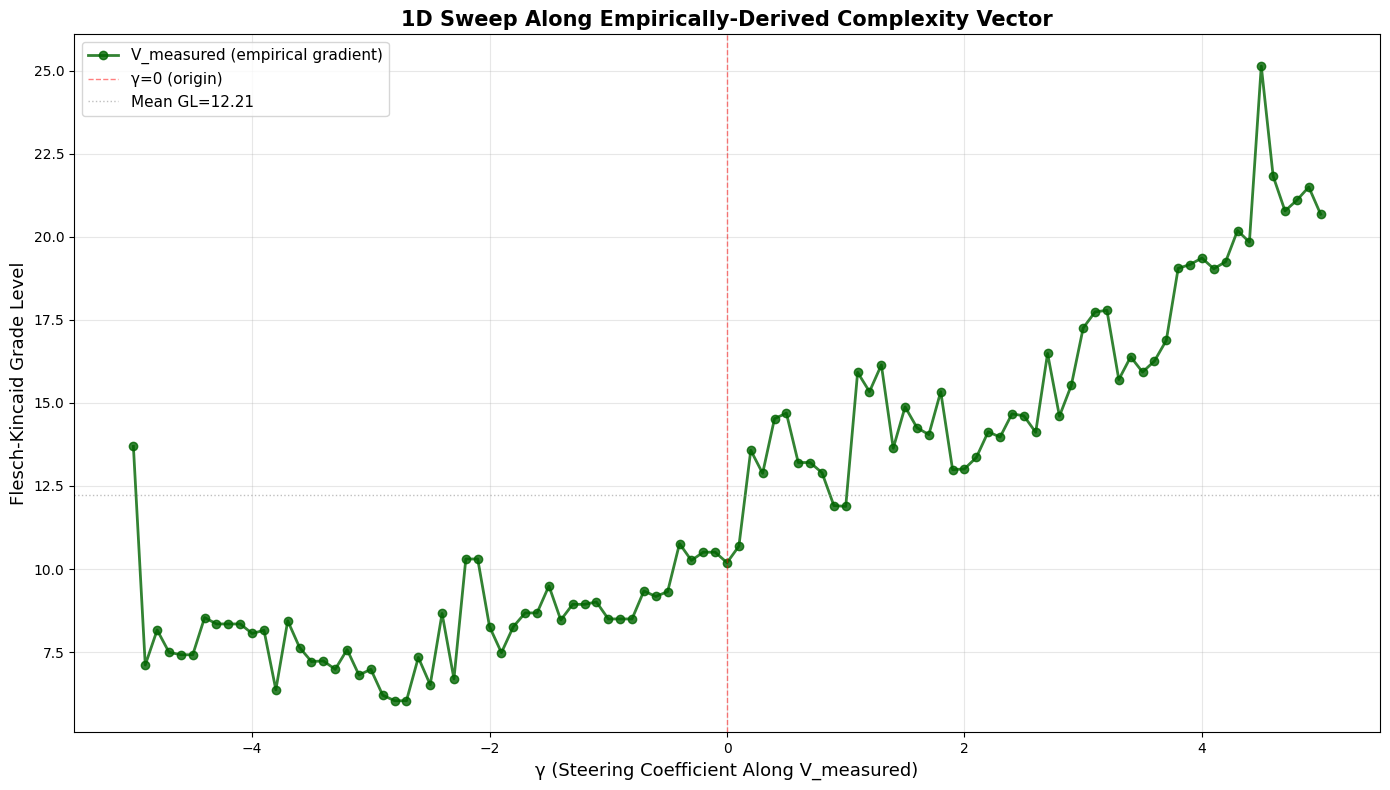


Key Questions:
  1. Is the relationship linear?
  2. Are there discontinuities like the α≈0.25 kink in V_complexity?
  3. What's the slope (dGL/dγ)?


In [9]:
fig, ax = plt.subplots(figsize=(14, 8))

# Plot V_measured sweep
ax.plot(df['gamma'], df['flesch_kincaid_grade'], 
        'o-', linewidth=2, markersize=6, color='darkgreen', 
        label='V_measured (empirical gradient)', alpha=0.8)

# Add reference lines
ax.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='γ=0 (origin)')
ax.axhline(df['flesch_kincaid_grade'].mean(), color='gray', linestyle=':', 
          linewidth=1, alpha=0.5, label=f'Mean GL={df["flesch_kincaid_grade"].mean():.2f}')

# Labels
ax.set_xlabel('γ (Steering Coefficient Along V_measured)', fontsize=13)
ax.set_ylabel('Flesch-Kincaid Grade Level', fontsize=13)
ax.set_title('1D Sweep Along Empirically-Derived Complexity Vector', 
            fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Questions:")
print("  1. Is the relationship linear?")
print("  2. Are there discontinuities like the α≈0.25 kink in V_complexity?")
print("  3. What's the slope (dGL/dγ)?")

In [10]:
# Linear regression to quantify the relationship
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(df['gamma'], df['flesch_kincaid_grade'])

print("Linear Regression: GL vs γ")
print("=" * 60)
print(f"GL = {slope:.4f}·γ + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"p-value = {p_value:.2e}")
print(f"Standard error = {std_err:.4f}")
print()
print("Interpretation:")
print(f"  • Slope: {slope:.4f} grade levels per unit γ")
print(f"  • Moving from γ=-5 to γ=+5 produces {slope*10:.2f} GL change")
print(f"  • {'Strong' if r_value**2 > 0.9 else 'Moderate' if r_value**2 > 0.7 else 'Weak'} linear relationship (R²={r_value**2:.3f})")

Linear Regression: GL vs γ
GL = 1.4302·γ + 12.2139
R² = 0.8315
p-value = 4.51e-40
Standard error = 0.0647

Interpretation:
  • Slope: 1.4302 grade levels per unit γ
  • Moving from γ=-5 to γ=+5 produces 14.30 GL change
  • Moderate linear relationship (R²=0.832)


## Step 7: Load Original V_complexity Data for Comparison

We need to compare against the original 1D sweep along V_complexity (β=0 row from the 2D scan).

In [11]:
# Load the 2D scan data and extract the β=0 row (pure V_complexity steering)
df_2d = pd.read_csv('data/qwen_2d_grid_results.csv')

# Filter for β ≈ 0 (pure alpha steering)
df_alpha = df_2d[np.abs(df_2d['beta']) < 0.01].sort_values('alpha').reset_index(drop=True)

print(f"Extracted {len(df_alpha)} points along pure V_complexity axis (β≈0)")
print(f"Alpha range: [{df_alpha['alpha'].min():.2f}, {df_alpha['alpha'].max():.2f}]")

Extracted 402 points along pure V_complexity axis (β≈0)
Alpha range: [-1.00, 1.00]


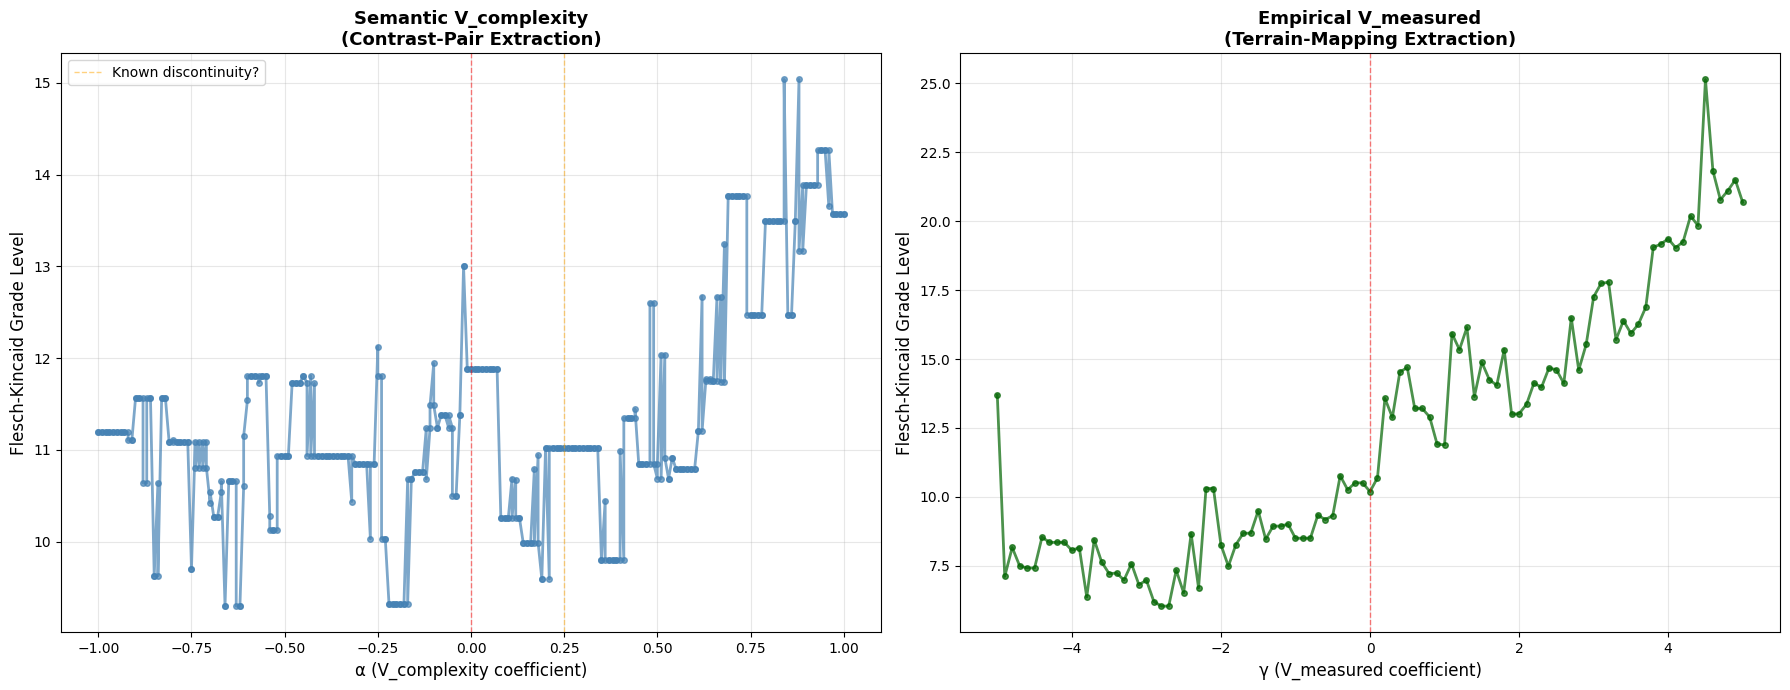


Comparison:
  V_complexity GL range: 9.30 - 15.04
  V_measured GL range:   6.03 - 25.15


In [12]:
# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Left: V_complexity (semantic extraction)
ax1.plot(df_alpha['alpha'], df_alpha['flesch_kincaid_grade'], 
        'o-', linewidth=2, markersize=4, color='steelblue', alpha=0.7)
ax1.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(0.25, color='orange', linestyle='--', linewidth=1, alpha=0.5, 
           label='Known discontinuity?')
ax1.set_xlabel('α (V_complexity coefficient)', fontsize=12)
ax1.set_ylabel('Flesch-Kincaid Grade Level', fontsize=12)
ax1.set_title('Semantic V_complexity\n(Contrast-Pair Extraction)', 
             fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: V_measured (empirical extraction)
ax2.plot(df['gamma'], df['flesch_kincaid_grade'], 
        'o-', linewidth=2, markersize=4, color='darkgreen', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('γ (V_measured coefficient)', fontsize=12)
ax2.set_ylabel('Flesch-Kincaid Grade Level', fontsize=12)
ax2.set_title('Empirical V_measured\n(Terrain-Mapping Extraction)', 
             fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparison:")
print(f"  V_complexity GL range: {df_alpha['flesch_kincaid_grade'].min():.2f} - {df_alpha['flesch_kincaid_grade'].max():.2f}")
print(f"  V_measured GL range:   {df['flesch_kincaid_grade'].min():.2f} - {df['flesch_kincaid_grade'].max():.2f}")

## Conclusion

**What did we learn?**

1. Does V_measured produce a more linear relationship?
2. Does it avoid discontinuities?
3. Is empirical extraction fundamentally different from semantic extraction?
4. What does this tell us about the "true" complexity direction in activation space?